In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipd
from pathlib import Path
import obspy as op
from obspy.core import read

In [2]:
ruta="/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/Dataset/VT/sismoVTobspy.txt"

In [3]:
def preprocesamiento(Ruta, Detrend='demean', New_Sampling=0, Filter='bandpass', Fmin=0.1, Fmax=35):

    '''
    Ruta: ruta de acceso del archivo
    Detrend: remueve la tendencia lineal
             'demean': remueve promedio de la serie
             'constant': extrae tendencia lineal con una recta entre el primer y último valor
             'linear': extrae la tendencia usando una aproximación por mínimos cuadrados
    New_Sampling: Nueva frecuencia de muestreo si se desea remuestrear. Fijar en 0 si no desea remuestreo
    Filter: filtro deseado
             'bandpass': pasa banda
             'highpass': pasa alto (toma Fmin como frecuencia de corte)
             'lowpass': pasa bajo (toma Fmax como frecuencia de corte)
             'bandstop': band stop
    Fmin: frecuencia mínima para el filtro
    Fmax: frecuencia máxima para el filtro
    '''
    
    #Importar los datos
    st = read(Ruta)
    tr = st[0]
    
    #Remover tendencia lineal
    sismo = tr.detrend(Detrend)
    
    #Reducir frecuencia de muestreo
    if New_Sampling > 0 and New_Sampling < sismo.stats.sampling_rate:
        sismo = sismo.decimate(round(sismo.stats.sampling_rate / New_Sampling))
    
    #Filtro
    if Filter == 'bandpass':
        sismo.filter(Filter, freqmin=Fmin, freqmax=Fmax)
    elif Filter == 'highpass':
        sismo.filter(Filter, freq=Fmin)
    elif Filter == 'lowpass':
        sismo.filter(Filter, freq=Fmax)
    elif Filter == 'bandstop':
        sismo.filter(Filter, freqmin=Fmin, freqmax=Fmax)
    else:
        print('error')

    #Convierte los datos a formato deseado
    salida = tf.convert_to_tensor(sismo, dtype=tf.float32)

    return salida,sismo



In [4]:
def get_spectrogram(waveform, ns=300, sol=0.5):
    '''
    waveform = señal
    ns = número de muestras por sección
    sol = porcentaje de solapamiento
    '''
    frame_length = round(waveform.shape[0] / (ns-(ns-1)*sol))
    print('FRAME_L = ',frame_length)
    frame_step = round(sol*frame_length)
    
    #frame_length = 255
    #frame_step = 128
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([waveform.shape[0]] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)
    
    # Option 1: Use tfio to get the spectrogram
    #spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)
    
    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectro = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step, window_fn=tf.signal.hamming_window)
    spectrogram = tf.abs(spectro)

    return spectrogram#, spect

## This funciton has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [119]:
def plot_spectrogram(spectrogram, ax, title, lf=0, uf=50):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    '''
    lf = lower frec
    uf = upper frec
    '''
    
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    '''
    height = spectrogram.T.shape[0]
    width = spectrogram.T.shape[1]
    '''
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    
    #print('X: ', X)
    #print('Y: ', Y)
    ax.pcolormesh(log_spec)
    ax.set_xlim([0, len(X)])
    if uf>height:
        uf=height-1
    ax.set_ylim([lf, uf])
    ax.set_title(title)

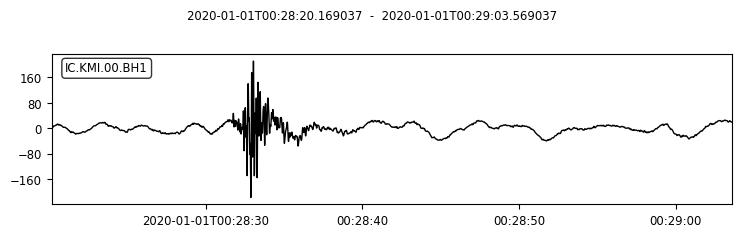

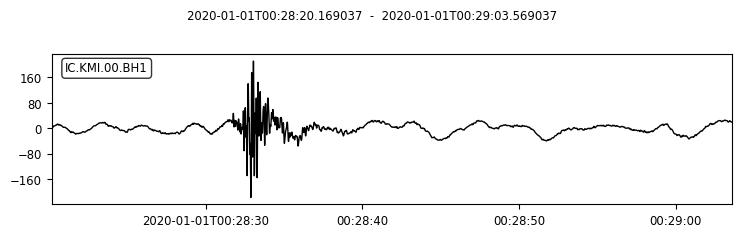

In [79]:
fmin = 0.01
fmax = 10

salida, sismo = preprocesamiento(ruta, Fmin=fmin, Fmax=fmax)
sismo.plot()

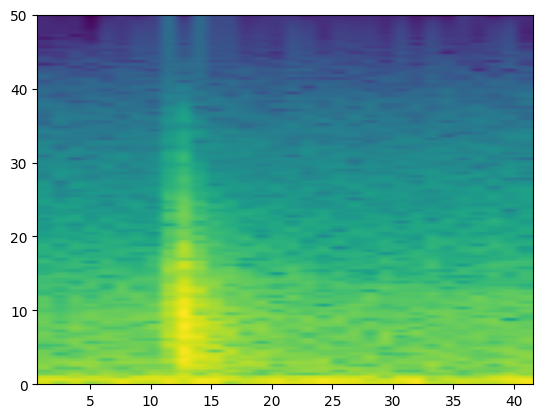

In [126]:
nfft = 2**8
sol=0.5

Pxx, freqs, bins, im = plt.specgram(sismo , NFFT=nfft, Fs=sismo.stats.sampling_rate, noverlap=round(nfft*sol))

In [171]:
Pxx.shape

(129, 32)

FRAME_L =  34
Label: VT
Waveform shape: (4341,)
Spectrogram shape: (254, 33)


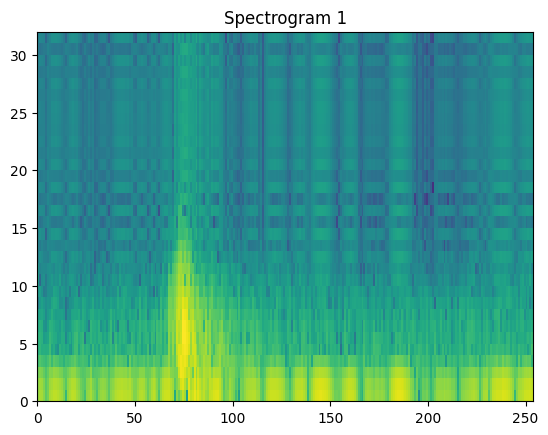

In [120]:
ns = 2**8 #directamente proporcional a la resolución en el tiempo, inversamente a la resolución en frecuencia
sol = 0.5
lf = 0
uf = 250
spectrogram = get_spectrogram(salida, ns, sol)

print('Label:', 'VT')
print('Waveform shape:', salida.shape)
print('Spectrogram shape:', spectrogram.shape)
#print('Spect shape:', spect.shape)


fig, ax = plt.subplots()  
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1', lf, uf)
plt.show()

#fig, ax = plt.subplots()  
#plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
#plt.show()